# Helper notebook for generating population samples with individuals in it
Get the 10% of the actual population as a representative sample

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from population_meta_data import Constants
from simulate_population import PopulationSampleGenerator

colors = ["#A42820", "#5F5647", "#9B110E", "#3F5151", "#4E2A1E", "#550307", "#0C1707"]

In [ ]:
#population class for generating population samples (individuals)
CONSTANTS = Constants.CONSTANTS
class PopulationSampleGenerator():
    def __init__(self, cast):
        self.cast = cast
        self.women_ratio = CONSTANTS['cast'][self.cast]['women_ratio']
        self.sample_size = CONSTANTS['cast'][self.cast]['sample_size']
        self.women_age_bins = CONSTANTS['cast'][self.cast]['women_age_bins']
        self.women_age_bin_prob = CONSTANTS['cast'][self.cast]['women_age_bin_prob']
        self.men_age_bins = CONSTANTS['cast'][self.cast]['men_age_bins']
        self.men_age_bin_prob = CONSTANTS['cast'][self.cast]['men_age_bin_prob']
        self.median_age = CONSTANTS['cast'][self.cast]['median_age']

    def simulateAge(self):
        #simulate women age first
        sample_size_women = int(round(self.sample_size * self.women_ratio, 0))
        probs = self.women_age_bin_prob / self.women_age_bin_prob.sum()
        bin_indices = np.random.choice(len(probs), size=sample_size_women, p=probs)
        women_samples = np.random.uniform(self.women_age_bins[bin_indices], self.women_age_bins[bin_indices + 1])

        #simulate men age
        sample_size_men = int(round(self.sample_size * (1-self.women_ratio), 0))
        probs = self.men_age_bin_prob / self.men_age_bin_prob.sum()
        bin_indices = np.random.choice(len(probs), size=sample_size_men, p=probs)
        men_samples = np.random.uniform(self.men_age_bins[bin_indices], self.men_age_bins[bin_indices + 1])

        df = pd.DataFrame({
            'idx': range(0, self.sample_size), 
            'age': np.concatenate(
                    [np.round(women_samples, 0).astype('int'),
                    np.round(men_samples, 0).astype('int')]
                    ), 
            'sex' :np.concatenate(
                    [np.zeros(int(round(self.sample_size * self.women_ratio, 0))).astype('int'),
                    np.ones(int(round(self.sample_size * (1-self.women_ratio)))).astype('int')]
                    )})
        
        return df

    def plotAge(self):
        df = self.simulateAge()
        # create plots for the age groups in cast 4
        men = df[df['sex'] == 1]['age']
        women = df[df['sex'] == 0]['age']
        df['age_group'] = pd.cut(df['age'], self.women_age_bins)

        age_pyramid = (
            df
            .groupby(['age_group', 'sex'])
            .size()
            .reset_index(name='count')
        )
        pyramid = age_pyramid.pivot(index='age_group', columns='sex', values='count').fillna(0)
        pyramid.columns = ['Women', 'Men']
        pyramid['Men'] = -pyramid['Men']
        pyramid = pyramid.iloc[::-1, ::-1]

        figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

        ax1.hist(women, bins=20, alpha=0.6, label='Women', color='salmon')
        ax1.axvline(self.median_age, color='k', linestyle='dashed', linewidth=1)
        ax1.hist(men, bins=20, alpha=0.6, label='Men', color='steelblue')
        ax1.legend()

        sns.barplot(
            x='Women', y=pyramid.index, data=pyramid.reset_index(), color='salmon', label='Women', order = pyramid.index

        )
        sns.barplot(
            x='Men', y=pyramid.index, data=pyramid.reset_index(), color='steelblue', label='Men', order = pyramid.index
        )
        plt.tight_layout()
        plt.savefig(f'{self.cast}cast_age_and_sex_plot.png')

        

In [ ]:
popsim = PopulationSampleGenerator("1st")
popsim.plotAge()

### Simulate yearly income

In [2]:

sim = PopulationSampleGenerator('4th')  
df = sim.simulateIncome()


In [ ]:
ages = df['age'].to_list()
counter = 0
original_mu = 9
samples = []
sigma = 1.03
# for age in ages: 
#     new_mu = original_mu + 0.3*((age-np.median(ages))/np.std(ages))
#     sample = np.random.lognormal(new_mu, sigma)
#     # print("Old mu:", original_mu, "new mu:", new_mu)
#     # print("Sample:", sample)
#     samples.append(sample)

samples = [np.random.lognormal(
    original_mu + 0.3*((age-np.median(ages))/np.std(ages)), sigma) 
    for age in ages]
print(np.mean(samples))
plt.hist(samples, bins=50)

### Create graphs for obsidian

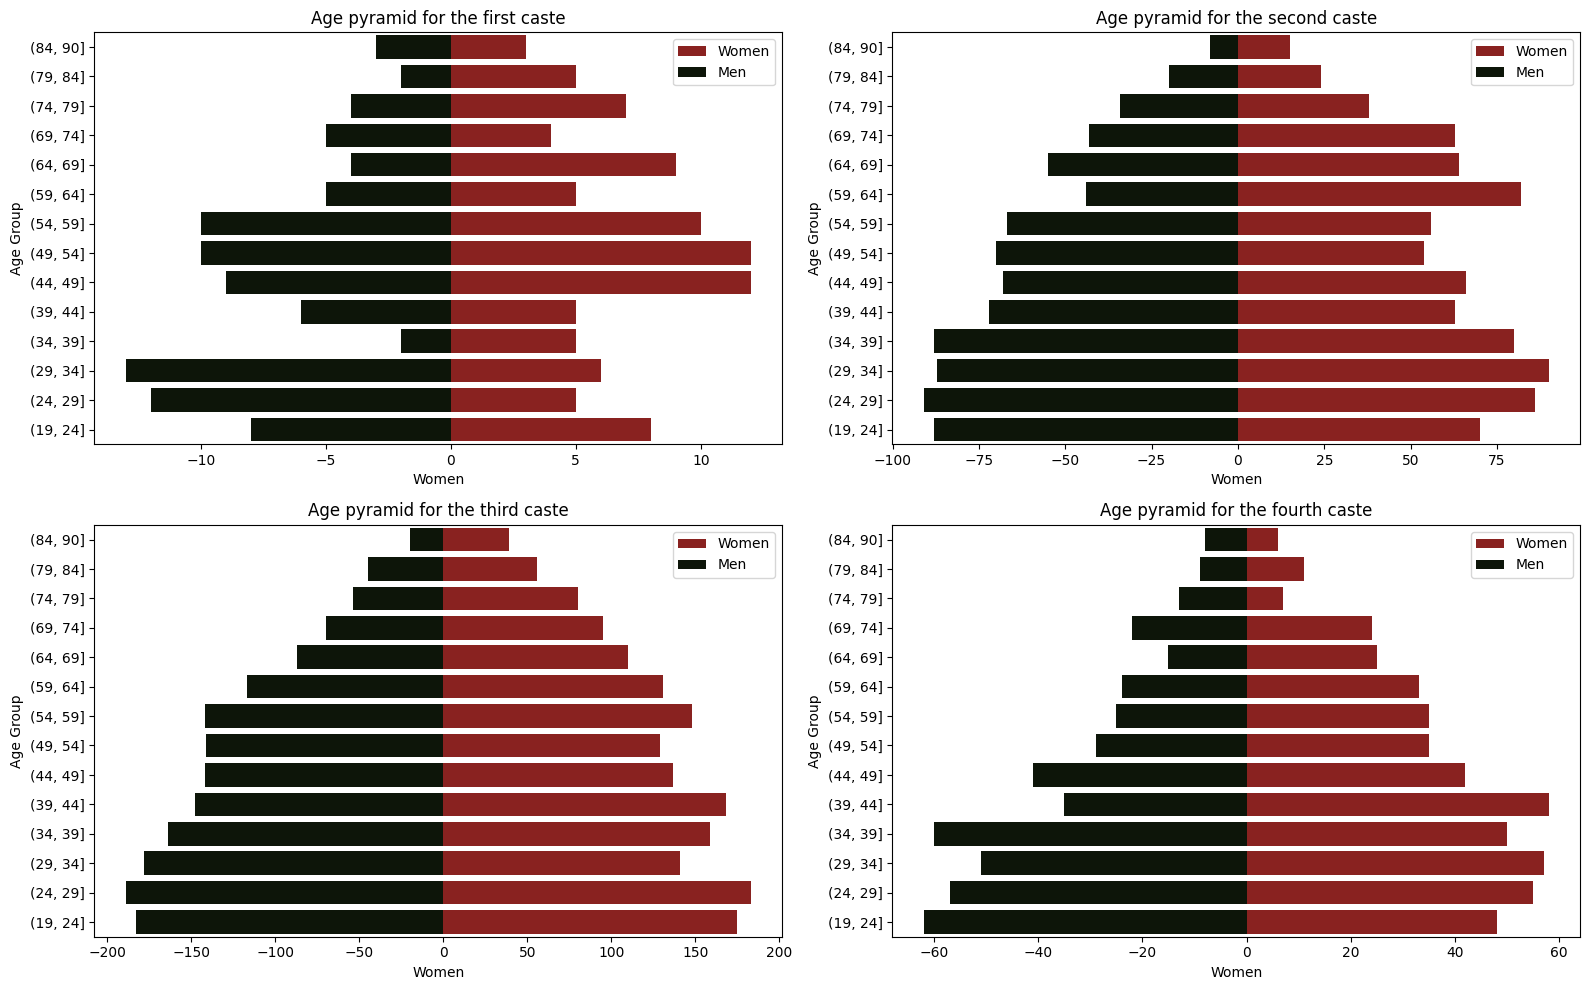

In [26]:
#graph age 
sim1 = PopulationSampleGenerator('1st')
sim2 = PopulationSampleGenerator('2nd')
sim3 = PopulationSampleGenerator('3rd')
sim4 = PopulationSampleGenerator('4th')

df1 = sim1.simulateIncome()
df2 = sim2.simulateIncome()
df3 = sim3.simulateIncome()
df4 = sim4.simulateIncome()

def pyramid(df):
    men = df[df['sex'] == 1]['age']
    women = df[df['sex'] == 0]['age']
    df['Age Group'] = pd.cut(df['age'], Constants.CONSTANTS['cast']['1st']['women_age_bins'])

    age_pyramid = (
        df
        .groupby(['Age Group', 'sex'], observed=True)
        .size()
        .reset_index(name='count')
    )
    pyramid = age_pyramid.pivot(index='Age Group', columns='sex', values='count').fillna(0)
    pyramid.columns = ['Women', 'Men']
    pyramid['Men'] = -pyramid['Men']
    pyramid = pyramid.iloc[::-1, ::-1]
    return pyramid

figure, ax = plt.subplots(2, 2, figsize=(16, 10))
ax = ax.flatten()
df_list = [df1, df2, df3, df4]
titles = ["Age pyramid for the first caste", "Age pyramid for the second caste", "Age pyramid for the third caste", "Age pyramid for the fourth caste"]

for i, df in enumerate(df_list):
    sns.barplot(
        x='Women', y=pyramid(df).index,
          data=pyramid(df).reset_index(),
            color=colors[2], label='Women',
              order = pyramid(df).index, ax=ax[i]
    )
    sns.barplot(
        x='Men', y=pyramid(df).index,
          data=pyramid(df).reset_index(),
            color=colors[6], label='Men',
              order = pyramid(df).index, ax=ax[i]
    )
    ax[i].set_title(titles[i])

plt.tight_layout()



Text(0.5, 1.0, 'Distribution of income for the fourth cast')

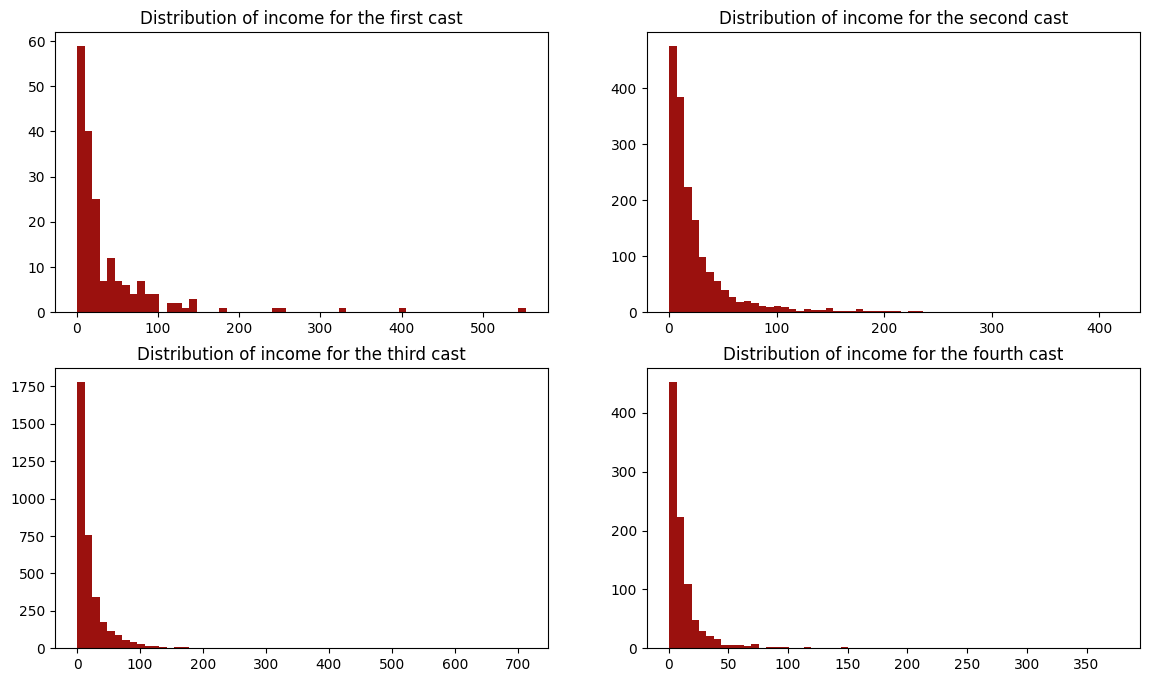

In [7]:
#simulate 4th cast age and income
sim1 = PopulationSampleGenerator('1st')
sim2 = PopulationSampleGenerator('2nd')
sim3 = PopulationSampleGenerator('3rd')
sim4 = PopulationSampleGenerator('4th')


df1 = sim1.simulateIncome()
df2 = sim2.simulateIncome()
df3 = sim3.simulateIncome()
df4 = sim4.simulateIncome()

income1 = (df1['income']/1000).to_list()
income2 = (df2['income']/1000).to_list()
income3 = (df3['income']/1000).to_list()
income4 = (df4['income']/1000).to_list()   

figure, ax = plt.subplots(2, 2, figsize=(14, 8))
ax[0, 0].hist(income1, bins=60, color=colors[2])
ax[0, 0].set_title('Distribution of income for the first cast')

ax[0, 1].hist(income2, bins=60, color=colors[2])
ax[0, 1].set_title('Distribution of income for the second cast')

ax[1, 0].hist(income3, bins=60, color=colors[2])
ax[1, 0].set_title('Distribution of income for the third cast')

ax[1, 1].hist(income4, bins=60, color=colors[2])
ax[1, 1].set_title('Distribution of income for the fourth cast')


Text(0.5, 1.0, 'Age vs income for the fourth cast')

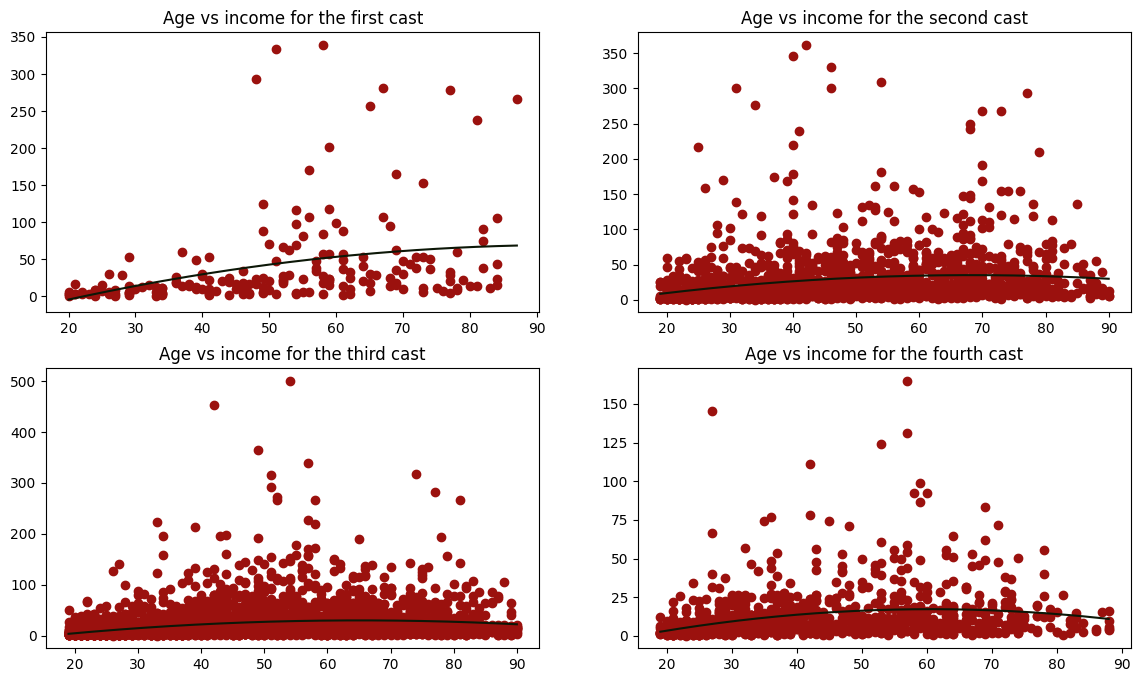

In [8]:
colors = ["#A42820", "#5F5647", "#9B110E", "#3F5151", "#4E2A1E", "#550307", "#0C1707"]

sim1 = PopulationSampleGenerator('1st')
sim2 = PopulationSampleGenerator('2nd')
sim3 = PopulationSampleGenerator('3rd')
sim4 = PopulationSampleGenerator('4th')


df1 = sim1.simulateIncome()
df2 = sim2.simulateIncome()
df3 = sim3.simulateIncome()
df4 = sim4.simulateIncome()

df1 = df1.sort_values(by=['age'])
x1, y1 = df1['age'].to_list(), (df1['income']/1000).to_list()
df2 = df2.sort_values(by=['age'])
x2, y2 = df2['age'].to_list(), (df2['income']/1000).to_list()
df3 = df3.sort_values(by=['age'])
x3, y3 = df3['age'].to_list(), (df3['income']/1000).to_list()
df4 = df4.sort_values(by=['age'])
x4, y4 = df4['age'].to_list(), (df4['income']/1000).to_list()


figure, ax = plt.subplots(2, 2, figsize=(14, 8))


z1 = np.polyfit(x1, y1, 2)
p1 = np.poly1d(z1)
ax[0, 0].scatter(x1, y1, color=colors[2])
ax[0, 0].plot(x1, p1(x1), color=colors[6])
ax[0, 0].set_title('Age vs income for the first cast')

z2 = np.polyfit(x2, y2, 2)
p2 = np.poly1d(z2)
ax[0, 1].scatter(x2, y2, color=colors[2])
ax[0, 1].plot(x2, p2(x2), color=colors[6])
ax[0, 1].set_title('Age vs income for the second cast')


z3 = np.polyfit(x3, y3, 2)
p3 = np.poly1d(z3)
ax[1, 0].scatter(x3, y3, color=colors[2])
ax[1, 0].plot(x3, p3(x3), color=colors[6])
ax[1, 0].set_title('Age vs income for the third cast')


z4 = np.polyfit(x4, y4, 2)
p4 = np.poly1d(z4)
ax[1, 1].scatter(x4, y4, color=colors[2])
ax[1, 1].plot(x4, p4(x4), color=colors[6])
ax[1, 1].set_title('Age vs income for the fourth cast')